# RQ3: How does the CNN perform on different image tasks and datasets?

## Experiment 1: Performance on different datasets

**Dataset 1: Brain MRI Images dataset:**<br>
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous. You can find it [here](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection). This dataset is then augmented according to the Data Augmentation notebook. After data augmentation, the dataset consists of 1085 positive and 980 examples, resulting in 2065 example images.

**Dataset 2: Brain Tumor MRI dataset:**<br>
This dataset contains 7023 images of human brain MRI images which are classified into 4 classes: glioma - meningioma - no tumor and pituitary. No tumor class images were taken from the Br35H dataset. You can find it [here](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).

**Dataset 3: Brain Tumor Classification (MRI) dataset:**<br>
The dataset holds 3260 images on T1-weighted contrast-enhanced images that were cleaned and augmented. You can find it [here](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri).

### Downloading the Brain Tumor MRI (Dataset 2) and Brain Tumor Classification (Dataset 3)

In [1]:
import os
import zipfile

# Create data directory and download
os.makedirs('data', exist_ok=True)
os.makedirs('data/brain-tumor-mri', exist_ok=True)
os.makedirs('data/brain-tumor-classification', exist_ok=True)
!curl -L -o data/brain-tumor-mri/brain-tumor-mri-dataset.zip https://www.kaggle.com/api/v1/datasets/download/masoudnickparvar/brain-tumor-mri-dataset
!curl -L -o data/brain-tumor-classification/brain-tumor-classification-dataset.zip https://www.kaggle.com/api/v1/datasets/download/sartajbhuvaji/brain-tumor-classification-mri

# Unzip the files
with zipfile.ZipFile('data/brain-tumor-mri/brain-tumor-mri-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('data/brain-tumor-mri/')

with zipfile.ZipFile('data/brain-tumor-classification/brain-tumor-classification-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('data/brain-tumor-classification/')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1  148M    1 2080k    0     0  1600k      0  0:01:35  0:00:01  0:01:34 2111k
  4  148M    4 7344k    0     0  3184k      0  0:00:47  0:00:02  0:00:45 3688k
  7  148M    7 11.5M    0     0  3589k      0  0:00:42  0:00:03  0:00:39 3969k
 12  148M   12 18.1M    0     0  4321k      0  0:00:35  0:00:04  0:00:31 4663k
 17  148M   17 25.3M    0     0  4894k      0  0:00:31  0:00:05  0:00:26 5203k
 21  148M   21 31.6M    0     0  5140k      0  0:00:29  0:00:06  0:00:23 6060k
 25  148M   25 37.6M    0     0  5279k      0  0:00:28  0:00:07  0:00:21 6246k
 28  148M   28 42.4M    0     0  5242k      0  0:0

## Import Necessary Modules

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

## Data Preparation & Preprocessing

In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [3]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

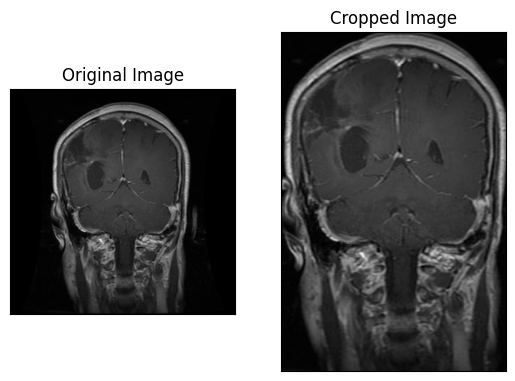

In [4]:
ex_img = cv2.imread('data/brain-tumor-mri/Training/glioma/Tr-gl_0010.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [5]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

### Restructure Dataset 2 and 3 to yes/no folders and balance the classes

In [24]:
import shutil
import os
import random

# Set random seed for reproducibility
random.seed(42)

# Define the base source and destination paths
base_data_path = "data"
new_structure_path = "data_restructured"

# List of datasets to process
datasets = ["brain-tumor-classification", "brain-tumor-mri"]

# Define tumor types for each dataset
dataset_tumor_types = {
    "brain-tumor-classification": {
        "tumor_types": ["glioma_tumor", "meningioma_tumor", "pituitary_tumor"],
        "no_tumor": "no_tumor"
    },
    "brain-tumor-mri": {
        "tumor_types": ["glioma", "meningioma", "pituitary"],
        "no_tumor": "notumor"
    }
}

for dataset in datasets:
    # Create dataset-specific restructured path
    dataset_restructured_path = os.path.join(new_structure_path, dataset)
    os.makedirs(dataset_restructured_path, exist_ok=True)
    os.makedirs(os.path.join(dataset_restructured_path, "yes"), exist_ok=True)
    os.makedirs(os.path.join(dataset_restructured_path, "no"), exist_ok=True)

    # Get the tumor types and no_tumor name for the current dataset
    tumor_types = dataset_tumor_types[dataset]["tumor_types"]
    notumor_type = dataset_tumor_types[dataset]["no_tumor"]

    # Copy tumor data into 'yes' (flattened) for the current dataset
    for tumor_type in tumor_types:
        for dataset_type in ["Testing", "Training"]:
            source_dir = os.path.join(base_data_path, dataset, dataset_type, tumor_type)
            if os.path.exists(source_dir):
                # Copy all files directly to 'yes'
                for item in os.listdir(source_dir):
                    source_item = os.path.join(source_dir, item)
                    if os.path.isfile(source_item):
                        destination_item = os.path.join(dataset_restructured_path, "yes", item)
                        # Avoid overwriting by adding a number if file exists
                        base_name, extension = os.path.splitext(item)
                        counter = 1
                        while os.path.exists(destination_item):
                            new_name = f"{base_name}_{counter}{extension}"
                            destination_item = os.path.join(dataset_restructured_path, "yes", new_name)
                            counter += 1
                        shutil.copy2(source_item, destination_item)

    # Copy notumor data into 'no' (flattened) for the current dataset
    for dataset_type in ["Testing", "Training"]:
        source_dir = os.path.join(base_data_path, dataset, dataset_type, notumor_type)
        if os.path.exists(source_dir):
            # Copy all files directly to 'no'
            for item in os.listdir(source_dir):
                source_item = os.path.join(source_dir, item)
                if os.path.isfile(source_item):
                    destination_item = os.path.join(dataset_restructured_path, "no", item)
                    # Avoid overwriting by adding a number if file exists
                    base_name, extension = os.path.splitext(item)
                    counter = 1
                    while os.path.exists(destination_item):
                        new_name = f"{base_name}_{counter}{extension}"
                        destination_item = os.path.join(dataset_restructured_path, "no", new_name)
                        counter += 1
                    shutil.copy2(source_item, destination_item)

    # Balance the dataset
    yes_path = os.path.join(dataset_restructured_path, "yes")
    no_path = os.path.join(dataset_restructured_path, "no")

    # Count the number of files in each folder for the current dataset
    yes_files = [f for f in os.listdir(yes_path) if os.path.isfile(os.path.join(yes_path, f))]
    no_files = [f for f in os.listdir(no_path) if os.path.isfile(os.path.join(no_path, f))]

    yes_count = len(yes_files)
    no_count = len(no_files)

    print(f"Before balancing ({dataset}): Yes: {yes_count}, No: {no_count}")

    # If yes has more samples than no, randomly remove samples from yes
    if yes_count > no_count:
        # Calculate how many to remove from yes to match no
        excess = yes_count - no_count
        # Randomly select files to remove
        files_to_remove = random.sample(yes_files, excess)
        # Remove the selected files
        for file in files_to_remove:
            os.remove(os.path.join(yes_path, file))

    # Recount after balancing
    yes_files = [f for f in os.listdir(yes_path) if os.path.isfile(os.path.join(yes_path, f))]
    no_files = [f for f in os.listdir(no_path) if os.path.isfile(os.path.join(no_path, f))]

    yes_count = len(yes_files)
    no_count = len(no_files)

    print(f"After balancing ({dataset}): Yes: {yes_count}, No: {no_count}")

Before balancing (brain-tumor-classification): Yes: 2764, No: 500
After balancing (brain-tumor-classification): Yes: 500, No: 500
Before balancing (brain-tumor-mri): Yes: 5023, No: 2000
After balancing (brain-tumor-mri): Yes: 2000, No: 2000


### Choose the dataset to train and evaluate the model on

In [101]:
# Dataset 1
# augmented_path = 'data_restructured/brain-tumor-classification/'

# Dataset 2
# augmented_path = 'data_restructured/brain-tumor-mri/'

# Dataset 3
augmented_path = '../../augmented data/'

In [102]:
# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


Each image has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [103]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

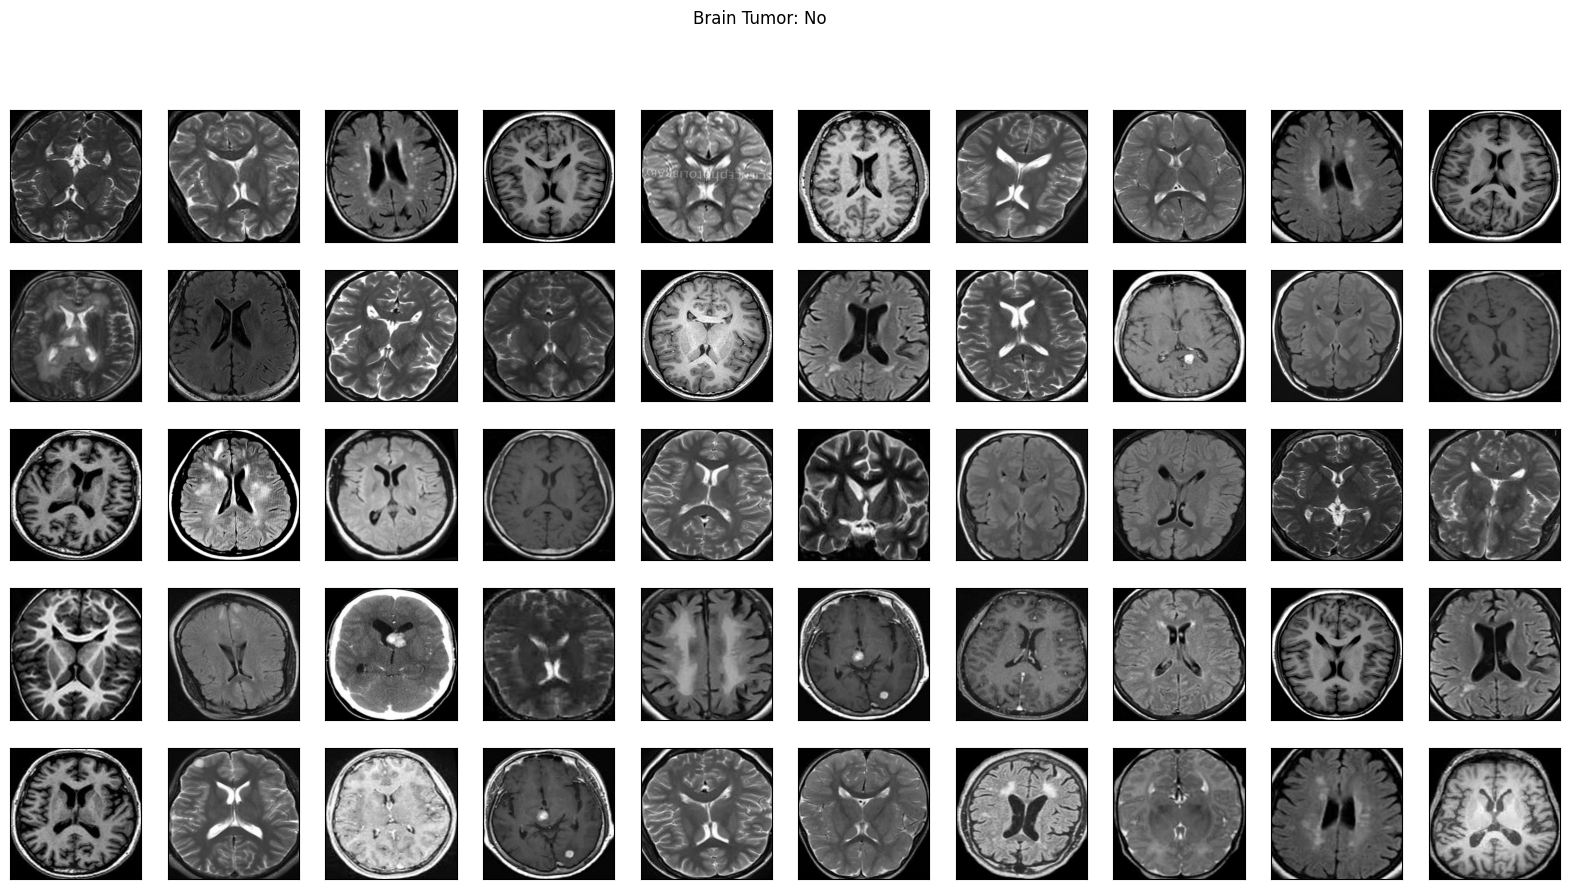

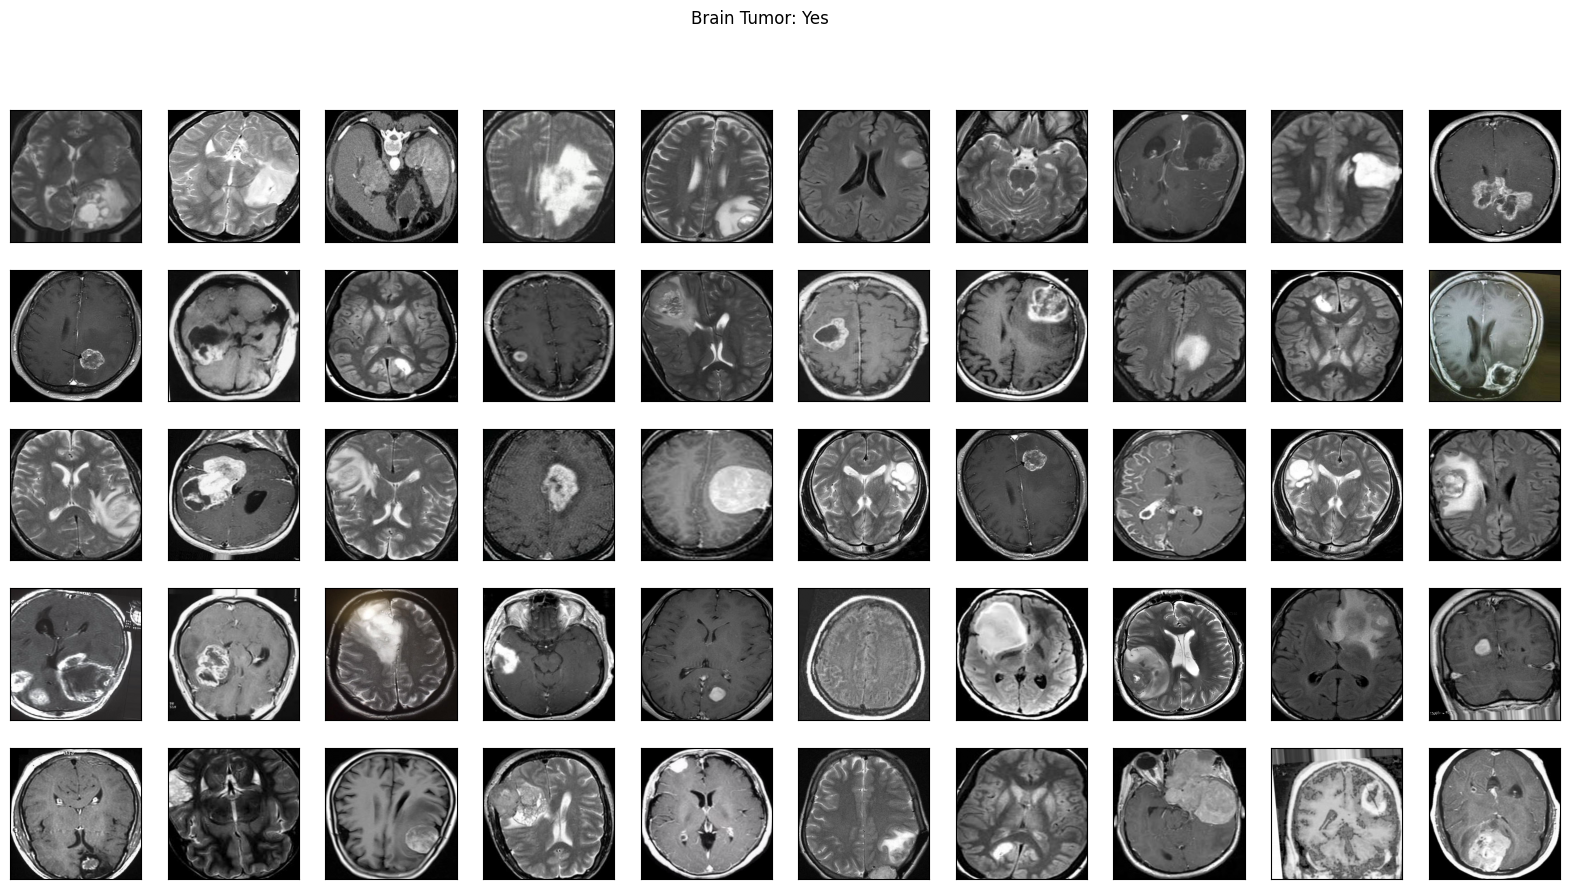

In [104]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [105]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [106]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [107]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


Some helper functions:

In [108]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [109]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

Let's build a convolutional neural network model:

In [110]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [111]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [112]:
model = build_model(IMG_SHAPE)

In [113]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_3                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

Compile the model:

In [114]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [115]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [116]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.keras".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

## Train the model

In [117]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 39s 805ms/step - accuracy: 0.5628 - loss: 1.1038 - val_accuracy: 0.5613 - val_loss: 0.6592
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 33s 716ms/step - accuracy: 0.7343 - loss: 0.5589 - val_accuracy: 0.7419 - val_loss: 0.5963
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 33s 722ms/step - accuracy: 0.8209 - loss: 0.3977 - val_accuracy: 0.7097 - val_loss: 0.5661
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 35s 756ms/step - accuracy: 0.8365 - loss: 0.3833 - val_accuracy: 0.6387 - val_loss: 0.5909
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 734ms/step - accuracy: 0.8473 - loss: 0.3304 - val_accuracy: 0.5581 - val_loss: 0.7807
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 738ms/step - accuracy: 0.8541 - loss: 0.3690 - val_accuracy: 0.7290 - val_loss: 0.4963
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 748ms/step - accuracy: 0.8853 - loss: 0.2891 - val_accuracy: 0.6548 - val_loss: 0.5980
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 35s 753ms/step - accuracy: 0.8725 - loss: 0.2958 - val_accu

In [118]:
history = model.history.history

In [119]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


## Plot Loss & Accuracy

In [120]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

**Note:** Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values. 

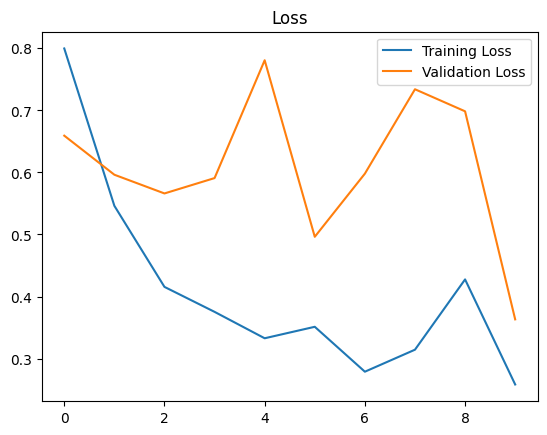

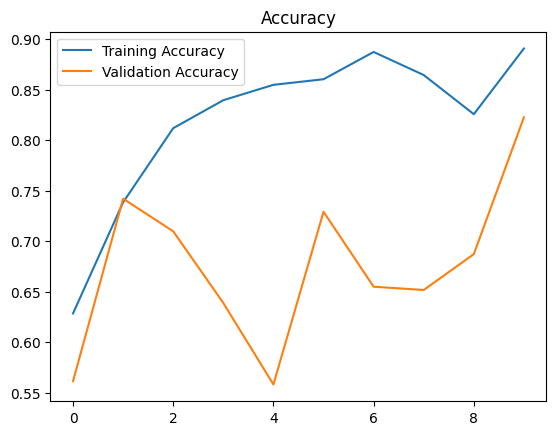

In [121]:
plot_metrics(history) 

# Results

Let's experiment with the best model (the one with the best validation accuracy):

Concretely, the model at the 23rd iteration with validation accuracy of 91%

### Load the best model

In [122]:
best_model = load_model(filepath='models/cnn-parameters-improvement-10-0.82.keras')

In [123]:
best_model.metrics_names

['loss', 'compile_metrics']

Evaluate the best model on the testing data:

In [124]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.8584 - loss: 0.3350


### Accuracy of the best model on the testing data:

In [125]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.31396928429603577
Test Accuracy = 0.8774193525314331


### F1 score for the best model on the testing data:

In [126]:
y_test_prob = best_model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


In [127]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.875


Let's also find the f1 score on the validation data:

In [128]:
y_val_prob = best_model.predict(X_val)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


In [129]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.8122866894197952


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [130]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [131]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [132]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 53.14878892733564%, number of pos examples: 768
Percentage of negative examples: 46.85121107266436%, number of neg examples: 677
Validation Data:
Number of examples: 310
Percentage of positive examples: 49.67741935483871%, number of pos examples: 154
Percentage of negative examples: 50.32258064516129%, number of neg examples: 156
Testing Data:
Number of examples: 310
Percentage of positive examples: 52.58064516129032%, number of pos examples: 163
Percentage of negative examples: 47.41935483870968%, number of neg examples: 147


As expected, the percentage of positive examples are around 50%.

[[139   8]
 [ 30 133]]


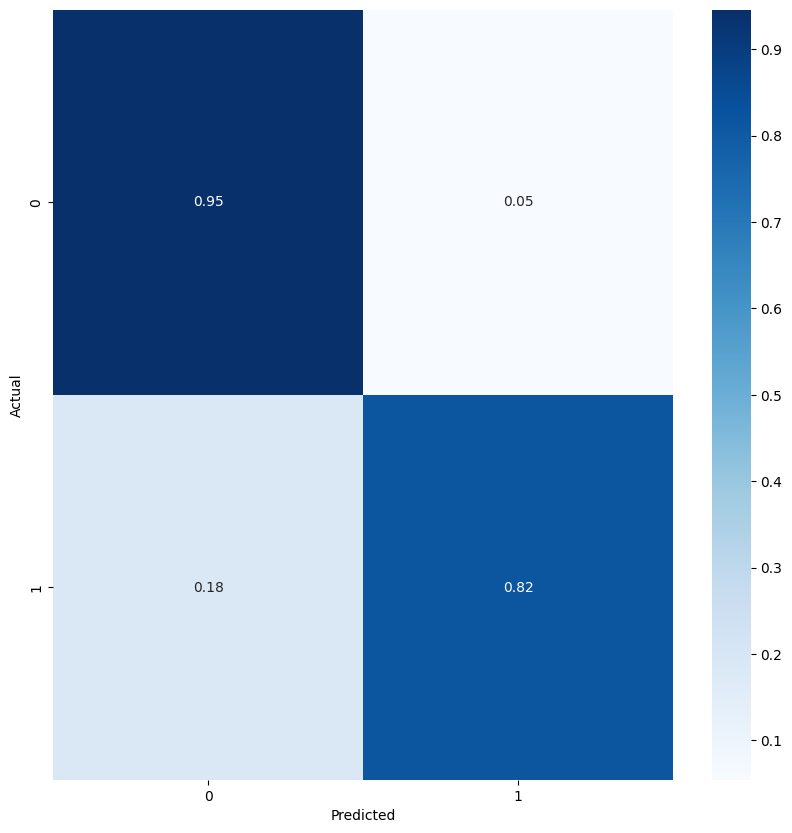

In [133]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    
    # Get confusion matrix
    cm  = confusion_matrix(y_true, y_pred)
    print(cm)
    
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
plot_confusion_matrix(y_test, y_test_pred)

# Conclusion

**Performance Table:**

| Metric     | Dataset 1 (Validation) | Dataset 1 (Test) | Dataset 2 (Validation) | Dataset 2 (Test) | Dataset 3 (Validation) | Dataset 3 (Test) |
|-----------|-----------------------|------------------|-----------------------|------------------|-----------------------|------------------|
| Accuracy  | 86%                   | 88%              | 96%                    | 94%               | 92%                    | 92%               |
| F1 Score  | 0.81                   | 0.88             | 0.96                    | 0.94               | 0.92                    | 0.92               |
